## Generate MCMC Sample data for the objective and goal

Given the historic data with clicks, impressions, spend, reach, and so on, build a model that can predict the probability of a specific _spend_ will result in clicks, impressions, reach, and so on.

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
# import tensorflow_probability as tfp
# import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
# from rezaware.modules.etl.loader import sparkFile as file
from mining.modules.budget.optimization import rwAdsDataFile as file

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write dataset for MCMC sampling"

clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    f_store_mode='local-fs',
    f_store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

All functional __PROPATTR__-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete
rwAdsData Class initialization complete

read and write dataset for MCMC sampling class initialization and load complete!


## Load Data

In [3]:
__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'
__def_opt_goal__= 'checkout'  # action group

_fpath = "mining/data/budget/optimization/objective"
_fname = "_".join([__def_obj__.lower(),__def_opt_goal__.lower()])
_fname +=".csv"

# kwargs = {
#     "REALMFILTATTR" : 'objective',
#     "REALMFILTLIST" : [__def_obj__],
#     "UNIXTIMESTAMP" : __def_date_attr__,
# }
sdf = clsFile.read_realm(
    realm = __def_realm__,
    to_date = None,
    from_date=None,
    fname = _fname,
    fpath = _fpath,
    # **kwargs,
)
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()


25/03/06 09:30:12 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/03/06 09:30:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/06 09:30:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

Loaded outcome_leads_checkout.csv 58280 rows


In [4]:
sdf.printSchema()

root
 |-- unix_updated_time: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- objective: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- purchase_roas: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- impressions: double (nullable = true)
 |-- clicks: double (nullable = true)
 |-- reach: double (nullable = true)
 |-- frequency: double (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPP: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- checkout_offsite_conversion__fb_pixel_add_to_cart: double (nullable = true)
 |-- checkout_offsite_conversion__fb_pixel_initiate_checkout: double (nullable = true)
 |-- checkout_offsite_conversion__fb_pixel_add_payment_info: double (nullable = true)



## Hamiltonian Monte Carlo for MCMC sampline
* Use Gaussian Process (GP) to model complex time-dependent patterns
* How to Incorporate DateTime into the Bayesian Model? To capture the effect of time in ad performance, you can:
   * Add a Time-Varying Component (Temporal Effects).
   * Treat time (e.g., days_since_start) as a continuous variable.
   * Model seasonality or trends using a Gaussian Process (GP) or a hierarchical time-series structure.

In [43]:
# Simulated Ad Performance Data
# spend = np.array([100, 200, 300, 400, 500], dtype=np.float32)
spend = np.array(sdf.select(F.col('spend')).na.fill(0).collect()).astype(np.float32).reshape(-1)
# clicks = np.array([50, 150, 300, 450, 600], dtype=np.float32)
clicks = np.array(sdf.select(F.col('clicks')).na.fill(0).collect()).astype(np.float32).reshape(-1)
# conversions = np.array([5, 20, 45, 80, 110], dtype=np.float32)
conversions = np.array(sdf.select(F.col('checkout_offsite_conversion__fb_pixel_add_to_cart')).na.fill(0).collect()).astype(np.float32).reshape(-1)


In [40]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

def run_bayesian_inference(spend, clicks, conversions):
    # Debug: Print input data
    print("Input Data:")
    print(f"Spend: {spend}")
    print(f"Clicks: {clicks}")
    print(f"Conversions: {conversions}")
    
    # Convert inputs to tensors with explicit float32 type
    spend = tf.convert_to_tensor(spend, dtype=tf.float32)
    clicks = tf.convert_to_tensor(clicks, dtype=tf.float32)
    conversions = tf.convert_to_tensor(conversions, dtype=tf.float32)

    def log_likelihood(alpha, ctr):
        # Add extensive debugging
        try:
            # Numerical stability checks
            lambda_clicks = tf.maximum(spend * alpha, 1e-10)
            
            # Poisson model for clicks with added numerical stability
            clicks_dist = tfd.Poisson(rate=lambda_clicks)
            clicks_logprob = clicks_dist.log_prob(clicks)

            # Binomial model for conversions with safety checks
            conversions_dist = tfd.Binomial(
                total_count=tf.maximum(clicks, 1),  # Ensure non-zero total count
                probs=tf.clip_by_value(ctr, 1e-10, 1.0 - 1e-10)  # Clip probabilities
            )
            conversions_logprob = conversions_dist.log_prob(conversions)

            return clicks_logprob + conversions_logprob
        
        except Exception as e:
            print(f"Likelihood computation error: {e}")
            raise

    def target_log_prob_fn(alpha, ctr):
        try:
            # Robust prior specifications
            alpha_prior = tfd.Gamma(
                concentration=tf.constant(2.0, dtype=tf.float32),  # Less restrictive
                rate=tf.constant(0.5, dtype=tf.float32)
            )
            
            ctr_prior = tfd.Beta(
                concentration1=tf.constant(2.0, dtype=tf.float32),  # Less restrictive
                concentration0=tf.constant(8.0, dtype=tf.float32)  # For lower CTR typical in ads
            )
            
            # Calculate log probabilities (not just the distribution objects)
            alpha_log_prob = alpha_prior.log_prob(alpha)
            ctr_log_prob = ctr_prior.log_prob(ctr)
            
            likelihood = log_likelihood(alpha, ctr)
            
            # Now adding log probabilities, not distribution objects
            return alpha_log_prob + ctr_log_prob + tf.reduce_sum(likelihood)
        
        except Exception as e:
            print(f"Target log prob computation error: {e}")
            raise

    # Compute initial state from data
    initial_alpha = np.sum(clicks) / np.sum(spend)
    initial_ctr = np.sum(conversions) / np.sum(clicks)
    
    print("\nInitial Estimates:")
    print(f"Initial Alpha: {initial_alpha}")
    print(f"Initial CTR: {initial_ctr}")

    # Ensure non-zero, non-NaN initial values
    initial_state = [
        tf.constant(max(1e-5, initial_alpha), dtype=tf.float32),
        tf.constant(max(1e-5, min(initial_ctr, 0.99)), dtype=tf.float32)
    ]
    print(f"Initial State: {initial_state}")

    # Sample chain with more diagnostics
    num_results = 4000
    num_burnin_steps = 1000

    # Create the step size adaptation kernel
    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.05
        ),
        num_adaptation_steps=int(0.8 * num_burnin_steps),
        target_accept_prob=0.8
    )

    # Define trace function for the dual averaging kernel
    @tf.function(autograph=False)
    def trace_fn(_, pkr):
        return pkr

    try:
        samples, kernel_results = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=initial_state,
            kernel=adaptive_kernel,
            trace_fn=trace_fn
        )

        # Explicitly convert to numpy with error checking
        samples_np = [s.numpy() for s in samples]
        
        # Check for NaNs
        for i, sample in enumerate(samples_np):
            if np.any(np.isnan(sample)):
                print(f"Warning: NaNs detected in sample {i}")
                print(f"Sample {i} details:")
                print(f"Min: {np.nanmin(sample)}")
                print(f"Max: {np.nanmax(sample)}")
                print(f"Mean: {np.nanmean(sample)}")

        # Diagnostics
        print("\nSampling Diagnostics:")
        
        # Extract acceptance rate from inner_results
        if hasattr(kernel_results, 'inner_results'):
            inner_results = kernel_results.inner_results
            if hasattr(inner_results, 'is_accepted'):
                acceptance_rate = tf.reduce_mean(tf.cast(inner_results.is_accepted, tf.float32)).numpy()
                print(f"Acceptance Rate: {acceptance_rate * 100:.2f}%")
            else:
                acceptance_rate = 0.0
                print("Could not access acceptance info in inner_results")
        else:
            acceptance_rate = 0.0
            print("No inner_results attribute found")
            
        # Print adaptation results
        if hasattr(kernel_results, 'new_step_size'):
            final_step = kernel_results.new_step_size[-1].numpy()
            print(f"Final adapted step size: {final_step}")
            
        # Print sample statistics
        print("\nFinal Results:")
        print(f"Alpha (Click Rate) - Mean: {np.mean(samples_np[0]):.4f}, "
              f"Std Dev: {np.std(samples_np[0]):.4f}, "
              f"Min: {np.min(samples_np[0]):.4f}, "
              f"Max: {np.max(samples_np[0]):.4f}")
        print(f"Conversion Rate - Mean: {np.mean(samples_np[1]):.4f}, "
              f"Std Dev: {np.std(samples_np[1]):.4f}, "
              f"Min: {np.min(samples_np[1]):.4f}, "
              f"Max: {np.max(samples_np[1]):.4f}")

        return samples_np, acceptance_rate

    except Exception as e:
        print(f"Sampling error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def visualize_posterior(samples, names=None):
    """Visualize posterior distributions from MCMC samples"""
    if samples is None:
        print("No samples to visualize")
        return
        
    if names is None:
        names = [f"Parameter {i+1}" for i in range(len(samples))]
        
    fig, axes = plt.subplots(len(samples), 2, figsize=(12, 4*len(samples)))
    
    for i, (sample, name) in enumerate(zip(samples, names)):
        # Histogram
        ax1 = axes[i, 0]
        ax1.hist(sample, bins=30, alpha=0.7, density=True)
        ax1.set_title(f"{name} Posterior Distribution")
        ax1.axvline(np.mean(sample), color='r', linestyle='--', label=f"Mean: {np.mean(sample):.4f}")
        ax1.legend()
        
        # Trace plot
        ax2 = axes[i, 1]
        ax2.plot(sample)
        ax2.set_title(f"{name} Trace Plot")
        ax2.set_xlabel("Sample")
        ax2.set_ylabel(name)
        
    plt.tight_layout()
    return fig


In [44]:
# Try this modified version of your Bayesian inference function

def run_bayesian_inference(spend, clicks, conversions):
    # Convert inputs to tensors with explicit float32 type
    spend = tf.convert_to_tensor(spend, dtype=tf.float32)
    clicks = tf.convert_to_tensor(clicks, dtype=tf.float32)
    conversions = tf.convert_to_tensor(conversions, dtype=tf.float32)
    
    # 1. Use a transformed model with unconstrained variables
    def joint_log_prob(unconstrained_alpha, unconstrained_ctr):
        # Transform unconstrained variables to their constrained space
        alpha = tf.exp(unconstrained_alpha)  # Map (-∞, ∞) to (0, ∞)
        ctr = tf.sigmoid(unconstrained_ctr)  # Map (-∞, ∞) to (0, 1)
        
        # Priors (in the unconstrained space)
        alpha_prior = tfd.Normal(loc=0.0, scale=1.0).log_prob(unconstrained_alpha)
        ctr_prior = tfd.Normal(loc=0.0, scale=1.0).log_prob(unconstrained_ctr)
        
        # Likelihood model
        lambda_clicks = tf.maximum(spend * alpha, 1e-10)
        clicks_dist = tfd.Poisson(rate=lambda_clicks)
        clicks_logprob = clicks_dist.log_prob(clicks)
        
        # For conversions, ensure clicks is at least 1
        safe_clicks = tf.maximum(clicks, 1.0)
        conversions_dist = tfd.Binomial(
            total_count=safe_clicks,
            probs=tf.clip_by_value(ctr, 1e-10, 1.0 - 1e-10)
        )
        conversions_logprob = conversions_dist.log_prob(conversions)
        
        return alpha_prior + ctr_prior + tf.reduce_sum(clicks_logprob) + tf.reduce_sum(conversions_logprob)
    
    # 2. Compute better initial values
    # Compute a stable initial alpha
    total_clicks = tf.reduce_sum(clicks).numpy()
    total_spend = tf.reduce_sum(spend).numpy()
    initial_alpha = total_clicks / total_spend if total_spend > 0 else 1.0
    
    # Compute a stable initial CTR
    total_conversions = tf.reduce_sum(conversions).numpy()
    initial_ctr = total_conversions / total_clicks if total_clicks > 0 else 0.1
    
    # Convert to unconstrained space 
    unconstrained_initial_alpha = np.log(initial_alpha)
    unconstrained_initial_ctr = np.log(initial_ctr / (1 - initial_ctr))
    
    print("\nInitial Estimates:")
    print(f"Initial Alpha: {initial_alpha} (unconstrained: {unconstrained_initial_alpha})")
    print(f"Initial CTR: {initial_ctr} (unconstrained: {unconstrained_initial_ctr})")
    
    # 3. Try HMC sampler instead of NUTS for more stability
    num_results = 2000
    num_burnin_steps = 1000
    
    # Set up initial state in unconstrained space
    initial_state = [
        tf.constant(unconstrained_initial_alpha, dtype=tf.float32),
        tf.constant(unconstrained_initial_ctr, dtype=tf.float32)
    ]
    
    # Simple HMC with fixed step size - more robust than adaptive NUTS in some cases
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=joint_log_prob,
        step_size=0.01,
        num_leapfrog_steps=5
    )
    
    # Add adaptation for step size
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=int(0.8 * num_burnin_steps),
        target_accept_prob=0.65
    )
    
    @tf.function(autograph=False)
    def trace_fn(_, pkr):
        return pkr
    
    # Run sampling
    try:
        samples, kernel_results = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=initial_state,
            kernel=adaptive_kernel,
            trace_fn=trace_fn
        )
        
        # Transform samples back to constrained space
        alpha_samples = tf.exp(samples[0]).numpy()
        ctr_samples = tf.sigmoid(samples[1]).numpy()
        
        # Extract acceptance info
        if hasattr(kernel_results, 'inner_results'):
            inner_results = kernel_results.inner_results
            if hasattr(inner_results, 'is_accepted'):
                acceptance_rate = tf.reduce_mean(tf.cast(inner_results.is_accepted, tf.float32)).numpy()
                print(f"Acceptance Rate: {acceptance_rate * 100:.2f}%")
        
        samples_np = [alpha_samples, ctr_samples]
        
        # Print results
        print("\nFinal Results:")
        print(f"Alpha (Click Rate) - Mean: {np.mean(alpha_samples):.4f}, "
              f"Std Dev: {np.std(alpha_samples):.4f}, "
              f"Min: {np.min(alpha_samples):.4f}, "
              f"Max: {np.max(alpha_samples):.4f}")
        print(f"Conversion Rate - Mean: {np.mean(ctr_samples):.4f}, "
              f"Std Dev: {np.std(ctr_samples):.4f}, "
              f"Min: {np.min(ctr_samples):.4f}, "
              f"Max: {np.max(ctr_samples):.4f}")
        
        return samples_np, acceptance_rate
        
    except Exception as e:
        print(f"Sampling error: {e}")
        import traceback
        traceback.print_exc()
        return None, None


Initial Estimates:
Initial Alpha: 1.0833463668823242 (unconstrained: 0.08005473762750626)
Initial CTR: 74394.1171875 (unconstrained: nan)
Acceptance Rate: 0.00%

Final Results:
Alpha (Click Rate) - Mean: 1.0833, Std Dev: 0.0000, Min: 1.0833, Max: 1.0833
Conversion Rate - Mean: nan, Std Dev: nan, Min: nan, Max: nan


ValueError: autodetected range of [nan, nan] is not finite

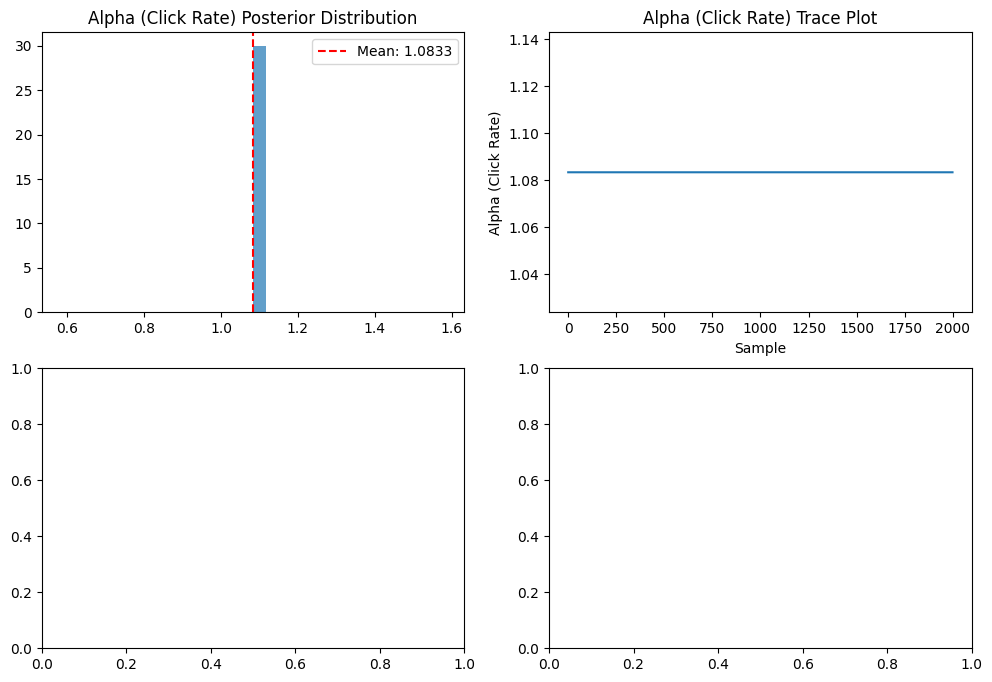

In [45]:
# Run the Bayesian inference
samples, acceptance_rate = run_bayesian_inference(spend, clicks, conversions)

# If you want to visualize the results
if samples is not None:
    fig = visualize_posterior(samples, ["Alpha (Click Rate)", "Conversion Rate"])
    plt.show()  # Display the plots


In [42]:
if samples is not None:
    print("\nFinal Results:")
    print("Alpha (Click Rate) - Mean: {:.4f}, Std Dev: {:.4f}, Min: {:.4f}, Max: {:.4f}".format(
        np.nanmean(samples[0]), np.nanstd(samples[0]), 
        np.nanmin(samples[0]), np.nanmax(samples[0])
    ))
    print("Conversion Rate - Mean: {:.4f}, Std Dev: {:.4f}, Min: {:.4f}, Max: {:.4f}".format(
        np.nanmean(samples[1]), np.nanstd(samples[1]), 
        np.nanmin(samples[1]), np.nanmax(samples[1])
    ))
    print(f"Acceptance Rate: {acceptance_rate * 100:.2f}%")


Final Results:
Alpha (Click Rate) - Mean: 1.0833, Std Dev: 0.0000, Min: 1.0833, Max: 1.0833
Conversion Rate - Mean: 0.9900, Std Dev: 0.0000, Min: 0.9900, Max: 0.9900
Acceptance Rate: 0.00%


In [25]:
samples[0], samples[1]

(array([1.0833464, 1.0833464, 1.0833464, ..., 1.0833464, 1.0833464,
        1.0833464], dtype=float32),
 array([0.99, 0.99, 0.99, ..., 0.99, 0.99, 0.99], dtype=float32))

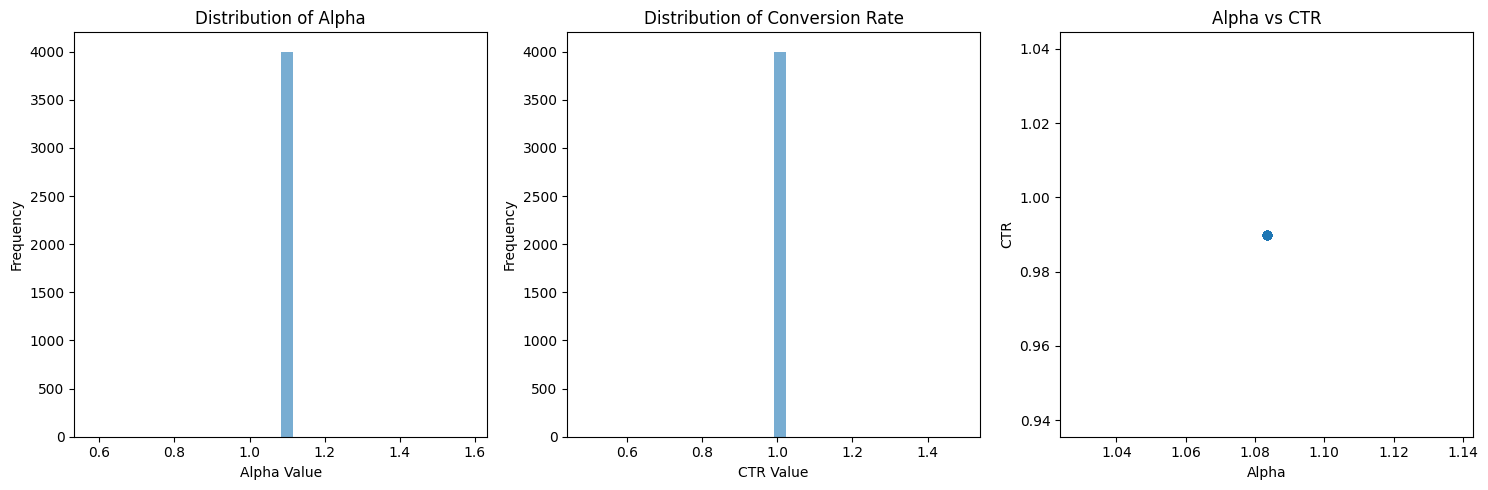


Final Results:
Alpha (Click Rate) - Mean: 1.0833, Std Dev: 0.0000, Min: 1.0833, Max: 1.0833
Conversion Rate - Mean: 0.9900, Std Dev: 0.0000, Min: 0.9900, Max: 0.9900
Acceptance Rate: 0.00%


In [21]:
if samples is not None:
    # Detailed diagnostic plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(samples[0], bins=30, alpha=0.6, label="Alpha")
    plt.title("Distribution of Alpha")
    plt.xlabel("Alpha Value")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 2)
    plt.hist(samples[1], bins=30, alpha=0.6, label="CTR")
    plt.title("Distribution of Conversion Rate")
    plt.xlabel("CTR Value")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 3)
    plt.scatter(samples[0], samples[1], alpha=0.1)
    plt.title("Alpha vs CTR")
    plt.xlabel("Alpha")
    plt.ylabel("CTR")
    
    plt.tight_layout()
    plt.show()

    # Detailed diagnostic printing
    print("\nFinal Results:")
    print("Alpha (Click Rate) - Mean: {:.4f}, Std Dev: {:.4f}, Min: {:.4f}, Max: {:.4f}".format(
        np.nanmean(samples[0]), np.nanstd(samples[0]), 
        np.nanmin(samples[0]), np.nanmax(samples[0])
    ))
    print("Conversion Rate - Mean: {:.4f}, Std Dev: {:.4f}, Min: {:.4f}, Max: {:.4f}".format(
        np.nanmean(samples[1]), np.nanstd(samples[1]), 
        np.nanmin(samples[1]), np.nanmax(samples[1])
    ))
    print(f"Acceptance Rate: {acceptance_rate * 100:.2f}%")

## Write objective & goal data to file

In [52]:
__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'
__def_opt_goal__

_fpath = "mining/data/budget/optimization/objective"
_fname = "_".join([__def_obj__.lower(),__def_opt_goal__.lower()])
_fname +=".csv"

write_data = clsFile.write_realm(
    realm=__def_realm__,
    data =_obj_goal_sdf,
    fname=_fname,
    fpath=_fpath,
)
print("saved %d data rows to %s" 
      %(_obj_goal_sdf.count(), write_data.upper()))

[Stage 1078:============================================>           (4 + 1) / 5]

saved 58280 data rows to /HOME/NUWAN/WORKSPACE/MADGICX/MINING/DATA/BUDGET/OPTIMIZATION/OBJECTIVE/OUTCOME_LEADS_CHECKOUT.CSV


In [7]:
obj_sdf.printSchema()

root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPP: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- objective: string (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- business_country_code: string (nullable = true)
 |-- business_city: string (nullable = true)
 |-- business_state: string (nullable = true)
 |-- timezone_name: string (nullable = true)
 |-- d1_view: double (nullable = true)
 |-- d7_view: double (nullable = true)
 |-- d28_view: double (nullable = true)
 |-- d1_click: double (nullable = true)
 |-- d7_click: double (n

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
scaled_arr = scaler.fit_transform(_plot_df[_act_met_cols_lst])
scaled_arr

array([[9.37495635e-07, 6.05960405e-04, 1.57423830e-02],
       [4.31600239e-06, 2.55332090e-01, 1.89349113e-02],
       [2.17828436e-06, 7.86019924e-05, 1.10635031e-01],
       [5.64449338e-07, 5.37139148e-05, 4.88539078e-05],
       [5.83393251e-07, 3.35899590e-05, 6.29119751e-04],
       [6.18729918e-07, 2.31401675e-04, 8.32152986e-03],
       [1.00000000e+00, 1.13202009e-04, 5.19076931e-02],
       [6.80268877e-07, 6.09142365e-05, 8.17157021e-03],
       [1.06622809e-06, 4.21536440e-03, 2.53092714e-02],
       [5.31499361e-06, 1.33116559e-04, 1.82910435e-01],
       [9.21398593e-07, 3.50233770e-05, 8.59839179e-03],
       [3.40832010e-07, 4.07962080e-01, 1.74572106e-03],
       [8.76555827e-06, 1.00000000e+00, 4.72266028e-01],
       [2.06757236e-06, 1.61512889e-03, 1.74369791e-02],
       [1.22107365e-05, 1.42476138e-03, 1.00000000e+00],
       [5.47567397e-08, 2.87349081e-05, 2.66488359e-02],
       [2.73860367e-06, 2.27150568e-04, 1.59766841e-02],
       [9.15063955e-08, 9.20999

In [18]:
scaled_arr=np.array(_plot_df[_act_met_cols_lst])
scaled_arr

array([[4.67780930e+05, 2.74321082e+06, 9.08055000e+03],
       [2.13000527e+06, 1.15590020e+09, 1.09220700e+04],
       [1.07824862e+06, 3.55834860e+05, 6.38167000e+04],
       [2.84242260e+05, 2.43165380e+05, 2.81800000e+01],
       [2.93562660e+05, 1.52063300e+05, 3.62890000e+02],
       [3.10948290e+05, 1.04756610e+06, 4.80004000e+03],
       [4.91999716e+11, 5.12470740e+05, 2.99414900e+04],
       [3.41225440e+05, 2.75761570e+05, 4.71354000e+03],
       [5.31117260e+05, 1.90831499e+07, 1.45989400e+04],
       [2.62150866e+06, 6.02624830e+05, 1.05506730e+05],
       [4.59861190e+05, 1.58552450e+05, 4.95974000e+03],
       [1.74222600e+05, 1.84686323e+09, 1.00697000e+03],
       [4.31918547e+06, 4.52704632e+09, 2.72413350e+05],
       [1.02377835e+06, 7.31176331e+06, 1.00580300e+04],
       [6.01421218e+06, 6.44996074e+06, 5.76821820e+05],
       [3.34736500e+04, 1.30084260e+05, 1.53716300e+04],
       [1.35392556e+06, 1.02832114e+06, 9.21570000e+03],
       [5.15544700e+04, 4.16940

## Fit with Normal distribution

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters
    alpha_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpc")
    beta_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpc")

    alpha_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_roas")
    beta_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_roas")
    
    # Likelihoods
    cpc_pred = yield tfd.Normal(loc=alpha_cpc + beta_cpc * spend_scaled, scale=0.1, name="cpc_pred")
    cpm_pred = yield tfd.Normal(loc=alpha_cpm + beta_cpm * spend_scaled, scale=0.1, name="cpm_pred")
    ctr_pred = yield tfd.Normal(loc=alpha_ctr + beta_ctr * spend_scaled, scale=0.01, name="ctr_pred")
    roas_pred = yield tfd.Normal(loc=alpha_roas + beta_roas * spend_scaled, scale=0.1, name="roas_pred")

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 10000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(0.5),  # alpha_cpc
    tf.constant(0.1),  # beta_cpc
    tf.constant(10.0),  # alpha_cpm
    tf.constant(0.1),  # beta_cpm
    tf.constant(0.02),  # alpha_ctr
    tf.constant(0.01),  # beta_ctr
    tf.constant(4.0),  # alpha_roas
    tf.constant(0.1),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print("Completed generating samples")

## Fit with Gamma distribution

In [69]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters (using Gamma distributions for non-negativity)
    alpha_cpc = yield tfd.Gamma(
        concentration=1.0, 
        rate=1.0, 
        name="alpha_cpc")
    beta_cpc = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpc")
    
    alpha_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_roas")
    beta_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_roas")
    
    # Likelihoods (using Gamma distributions for non-negativity)
    cpc_pred = yield tfd.Gamma(
        concentration=alpha_cpc + beta_cpc * spend_scaled,
        rate=1.0,
        name="cpc_pred"
    )
    cpm_pred = yield tfd.Gamma(
        concentration=alpha_cpm + beta_cpm * spend_scaled,
        rate=1.0,
        name="cpm_pred"
    )
    ctr_pred = yield tfd.Gamma(
        concentration=alpha_ctr + beta_ctr * spend_scaled,
        rate=1.0,
        name="ctr_pred"
    )
    roas_pred = yield tfd.Gamma(
        concentration=alpha_roas + beta_roas * spend_scaled,
        rate=1.0,
        name="roas_pred"
    )

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 2000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(1.0),  # alpha_cpc
    tf.constant(1.0),  # beta_cpc
    tf.constant(1.0),  # alpha_cpm
    tf.constant(1.0),  # beta_cpm
    tf.constant(1.0),  # alpha_ctr
    tf.constant(1.0),  # beta_ctr
    tf.constant(1.0),  # alpha_roas
    tf.constant(1.0),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print('Completed generating Gama distribution data')


## Predict Performance for Spend Value

In [70]:
# Predict expected values for a given Spend
def predict(spend_value):
    # Scale the input Spend value
    spend_value_scaled = (spend_value - spend_mean) / spend_std
    
    # Compute predictions
    # cpc_pred = np.mean(alpha_cpc_samples + beta_cpc_samples * spend_value_scaled)
    # cpm_pred = np.mean(alpha_cpm_samples + beta_cpm_samples * spend_value_scaled)
    # ctr_pred = np.mean(alpha_ctr_samples + beta_ctr_samples * spend_value_scaled)
    # roas_pred = np.mean(alpha_roas_samples + beta_roas_samples * spend_value_scaled)
    cpc_pred = alpha_cpc_samples + beta_cpc_samples * spend_value_scaled
    cpm_pred = alpha_cpm_samples + beta_cpm_samples * spend_value_scaled
    ctr_pred = alpha_ctr_samples + beta_ctr_samples * spend_value_scaled
    roas_pred = alpha_roas_samples + beta_roas_samples * spend_value_scaled
    
    return cpc_pred, cpm_pred, ctr_pred, roas_pred

# Example prediction for a given Spend
spend_value = 72.56  # Replace with your desired Spend value
cpc_pred, cpm_pred, ctr_pred, roas_pred = predict(spend_value)

print(f"Expected CPC for Spend={spend_value}: {np.mean(cpc_pred)}")
print(f"Expected CPM for Spend={spend_value}: {np.mean(cpm_pred)}")
print(f"Expected CTR for Spend={spend_value}: {np.mean(ctr_pred)}")
print(f"Expected ROAS for Spend={spend_value}: {np.mean(roas_pred)}")

Expected CPC for Spend=72.56: 0.7994794249534607
Expected CPM for Spend=72.56: 0.7994794249534607
Expected CTR for Spend=72.56: 0.7994794249534607
Expected ROAS for Spend=72.56: 0.7994794249534607


In [ ]:
643.58975     4.068199    83.871559     3.038284     3.730636

In [43]:
_data_df[_data_df['spend_usd']<91]

,spend_usd,CPC,CPM,CTR,ROAS,click,impressions,frequency,reach
0,6.44,0.920000,11.398230,1.238938,18.636646,7,565,1.134538,498
1,5.00,1.000000,13.227513,1.322751,18.190000,5,378,1.192429,317
2,25.84,1.845714,29.397042,1.592719,9.854876,14,879,1.153543,762
3,16.29,1.086000,10.745383,0.989446,5.831799,15,1516,1.179767,1285
4,63.54,1.245882,55.933099,4.489437,8.462386,51,1136,1.347568,843
...,...,...,...,...,...,...,...,...,...
5397,72.56,0.980541,48.373333,4.933333,0.663589,74,1500,1.255230,1195
5398,49.69,1.014082,41.134106,4.056291,5.895150,49,1208,1.391705,868
5401,36.70,0.965789,34.819734,3.605313,3.442234,38,1054,1.299630,811
5406,19.59,0.932857,36.892655,3.954802,7.918836,21,531,1.149351,462
